# Regression Model for Kaggle Tabular Playground Series Feb 2021 Using Python and XGBoost
### David Lowe
### May 27, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Feb 2021 dataset is a regression modeling situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The February dataset may be synthetic but is based on a real dataset and generated using a CTGAN. The original dataset tries to predict the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS:  The performance of the preliminary XGBoost model achieved an RMSE benchmark of 0.8531. After a series of tuning trials, the refined XGBoost model processed the training dataset with a final RMSE score of 0.8434. When we applied the last model to Kaggle's test dataset, the model achieved an RMSE score of 0.8443.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground Series 2021 Feb Data Set

Dataset ML Model: Regression with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-feb-2021

One potential source of performance benchmarks: https://www.kaggle.com/c/tabular-playground-series-feb-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon May 24 20:27:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from xgboost import XGBRegressor

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.25

# Set the number of folds for cross validation
N_FOLDS = 5

# Set various default modeling parameters
SCORING_METRIC = 'neg_mean_squared_error'

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021feb/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id cat0 cat1 cat2 cat3  ...    cont10    cont11    cont12    cont13    target
0   1    A    B    A    A  ...  0.724417  0.701915  0.877618  0.719903  6.994023
1   2    B    A    A    A  ...  0.613252  0.741289  0.326679  0.808464  8.071256
2   3    A    A    A    C  ...  0.264104  0.695561  0.869133  0.828352  5.760456
3   4    A    A    A    C  ...  0.494269  0.698125  0.809799  0.614766  7.806457
4   6    A    B    A    A  ...  0.724447  0.683073  0.343457  0.297743  6.868974

[5 rows x 26 columns]


In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cont0   300000 non-null  float64
 12  cont1   300000 non-null  float64
 13  cont2   300000 non-null  float64
 14  cont3   300000 non-null  float64
 15  cont4   300000 non-null  float64
 16  cont5   300000 non-null  float64
 17  cont6   300000 non-null  float64
 18  cont7   300000 non-null  float64
 19  cont8   300000 non-null  float64
 20  cont9   300000 non-null  float64
 21  cont10  30

In [12]:
print(df_dataset_import.describe(include='all'))

                   id    cat0  ...         cont13         target
count   300000.000000  300000  ...  300000.000000  300000.000000
unique            NaN       2  ...            NaN            NaN
top               NaN       A  ...            NaN            NaN
freq              NaN  281471  ...            NaN            NaN
mean    250018.576947     NaN  ...       0.503349       7.456260
std     144450.150010     NaN  ...       0.225218       0.887295
min          1.000000     NaN  ...       0.158121       0.000000
25%     124772.500000     NaN  ...       0.291289       6.798341
50%     250002.500000     NaN  ...       0.433909       7.496503
75%     375226.500000     NaN  ...       0.730870       8.161166
max     499999.000000     NaN  ...       0.873579      10.309208

[11 rows x 26 columns]


In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [14]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

  cat0 cat1 cat2 cat3 cat4  ...    cont10    cont11    cont12    cont13    target
0    A    B    A    A    B  ...  0.724417  0.701915  0.877618  0.719903  6.994023
1    B    A    A    A    B  ...  0.613252  0.741289  0.326679  0.808464  8.071256
2    A    A    A    C    B  ...  0.264104  0.695561  0.869133  0.828352  5.760456
3    A    A    A    C    B  ...  0.494269  0.698125  0.809799  0.614766  7.806457
4    A    B    A    A    B  ...  0.724447  0.683073  0.343457  0.297743  6.868974

[5 rows x 25 columns]


In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

In [16]:
print(df_dataset_import.describe(include='all'))

          cat0    cat1    cat2  ...         cont12         cont13         target
count   300000  300000  300000  ...  300000.000000  300000.000000  300000.000000
unique       2       2       2  ...            NaN            NaN            NaN
top          A       A       A  ...            NaN            NaN            NaN
freq    281471  162678  276551  ...            NaN            NaN            NaN
mean       NaN     NaN     NaN  ...       0.524549       0.503349       7.456260
std        NaN     NaN     NaN  ...       0.220892       0.225218       0.887295
min        NaN     NaN     NaN  ...      -0.005600       0.158121       0.000000
25%        NaN     NaN     NaN  ...       0.332143       0.291289       6.798341
50%        NaN     NaN     NaN  ...       0.407365       0.433909       7.496503
75%        NaN     NaN     NaN  ...       0.732431       0.730870       8.161166
max        NaN     NaN     NaN  ...       0.961370       0.873579      10.309208

[11 rows x 25 columns]


In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = total_column_count

In [19]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_train = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_train = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_train = df_dataset_import.iloc[:,1:total_column_count]
    df_target_train = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 25) df_features_train.shape: (300000, 24) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

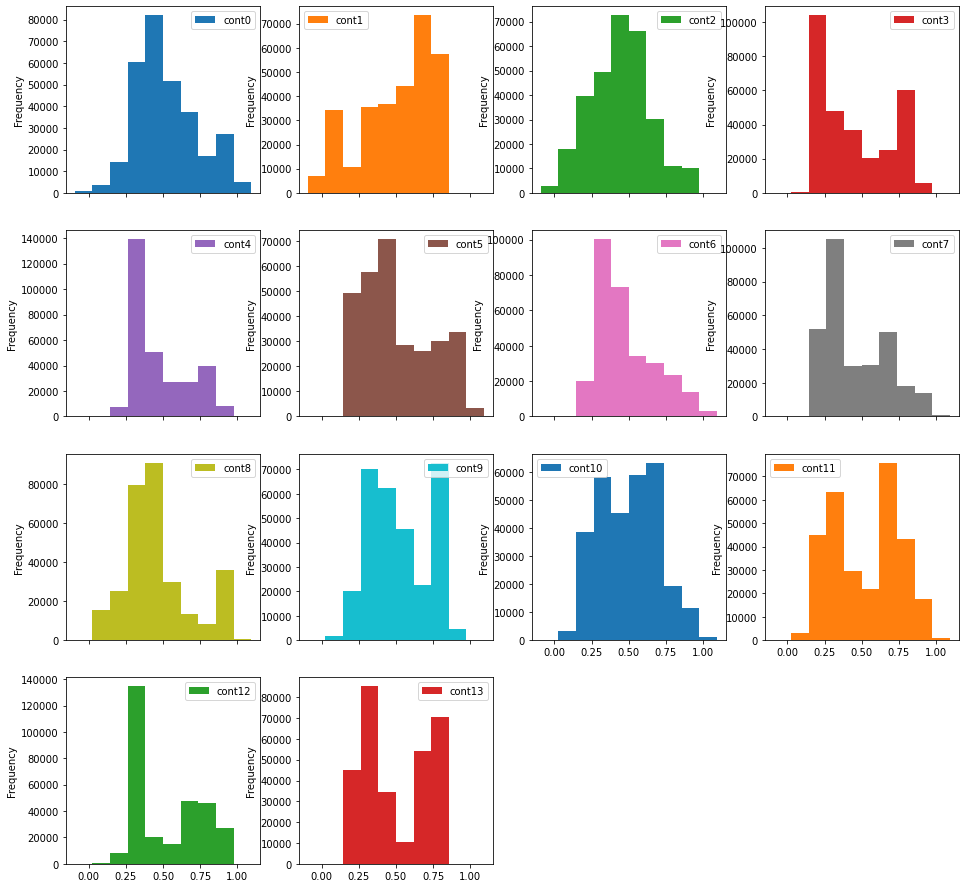

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

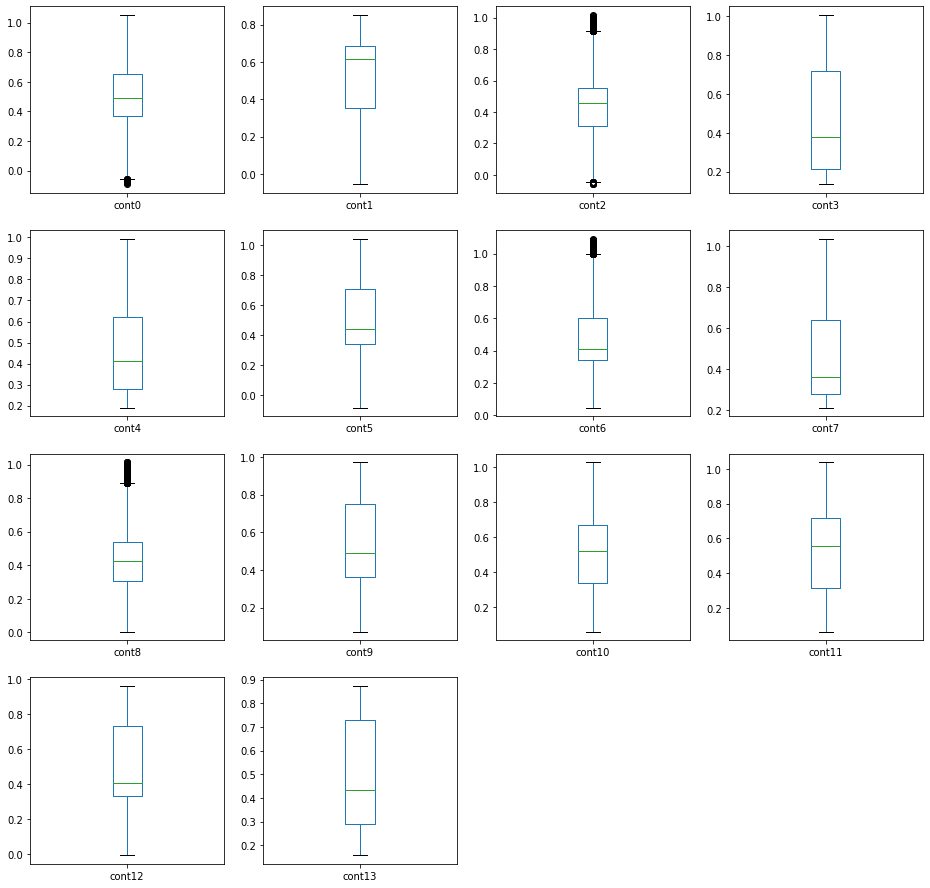

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

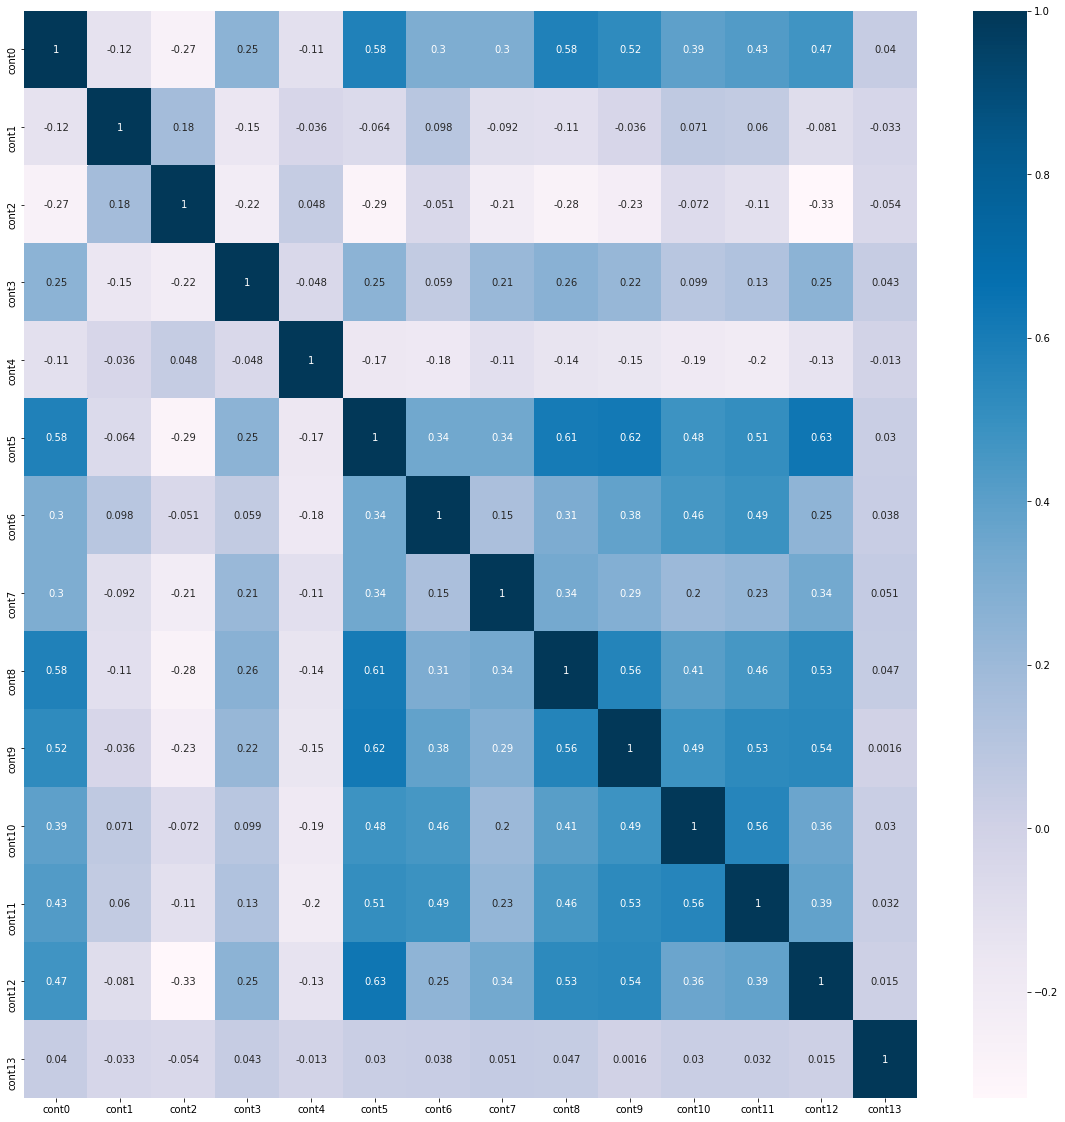

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [28]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=0))
#     ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool']).columns
categorical_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 14
Number of categorical columns: 10
Total number of columns in the feature dataframe: 24


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (300000, 24) to array_features_train.shape: (300000, 70)


### 3.c) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (300000, 70) array_target_train.shape: (300000,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Set up Algorithms Spot-Checking Array
start_time_module = datetime.now()
train_models = [('XGB', XGBRegressor(random_state=RNG_SEED, n_jobs=N_JOBS, objective='reg:squarederror', tree_method='gpu_hist'))]

In [37]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module))
	print ('RMSE for the model is:', math.sqrt((np.mean(cv_results.mean())*-1)))
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: -0.727821 (0.006872)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=888, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)
Model training time: 0:00:07.775855
RMSE for the model is: 0.8531245493700672


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.8s finished


### 4.b) Algorithm Tuning

In [38]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [39]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBRegressor(random_state=RNG_SEED, n_jobs=N_JOBS, objective='reg:squarederror', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(500, 1001, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([3, 4, 5]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE from all models is:', math.sqrt((np.mean(grid_result1.best_score_)*-1)))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 61.8min finished


Best: -0.711781 using {'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 1000}
-0.713110 (0.006379) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500}
-0.712509 (0.006275) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 600}
-0.712100 (0.006230) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 700}
-0.712005 (0.006123) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 800}
-0.711919 (0.006070) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 900}
-0.711895 (0.006061) with: {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 1000}
-0.713096 (0.006385) with: {'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 500}
-0.712466 (0.006286) with: {'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 600}
-0.712054 (0.006230) with: {'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 700}
-0.711830 (0.006148) with: {'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 800}
-0.711782 (0.006109) with: {'max_de

In [40]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBRegressor(n_estimators=1000, max_depth=3, min_child_weight=4, random_state=RNG_SEED, n_jobs=N_JOBS, objective='reg:squarederror', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]), colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE from all models is:', math.sqrt((np.mean(grid_result2.best_score_)*-1)))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 14.6min finished


Best: -0.711414 using {'colsample_bytree': 0.7, 'subsample': 0.8}
-0.711476 (0.006136) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
-0.711414 (0.006102) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
-0.711638 (0.006149) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
-0.711686 (0.006117) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
-0.711469 (0.006226) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
-0.711435 (0.006047) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
-0.711659 (0.005972) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
-0.711706 (0.005981) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
-0.711620 (0.005874) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
-0.711657 (0.005957) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
-0.711671 (0.006061) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
-0.711745 (0.006083) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
-0.711589 (0.006122) with: {'colsample_bytree': 1.0, 'subsample': 0.7}
-0.711611 (

### 4.c) Compare Algorithms After Tuning

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


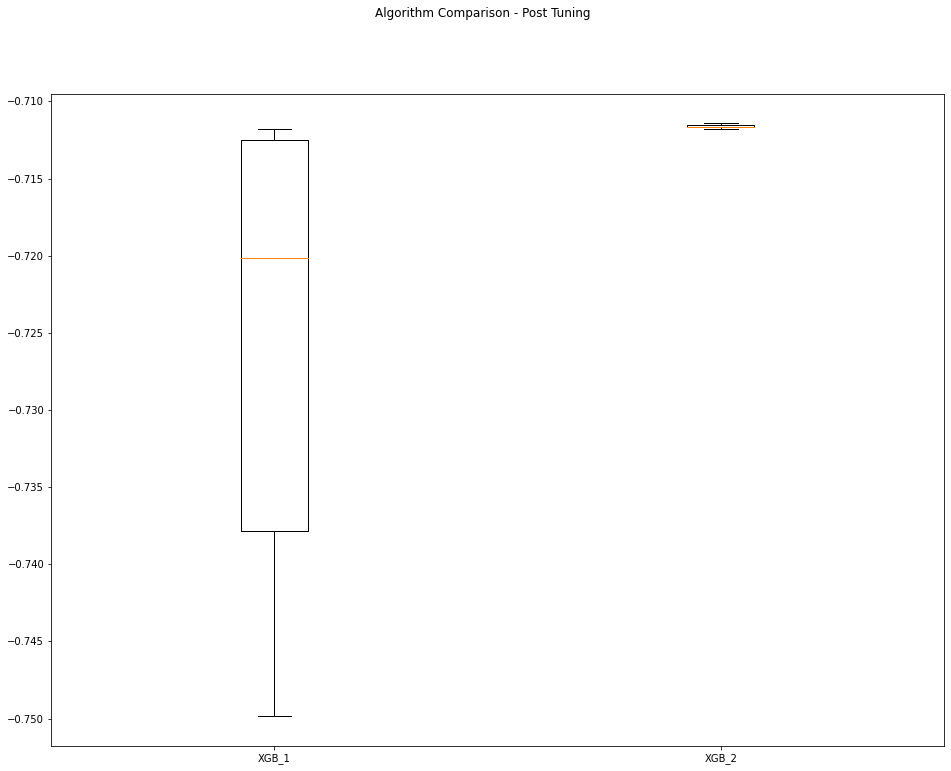

In [41]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [42]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [43]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [44]:
final_model = XGBRegressor(n_estimators=1000, max_depth=3, min_child_weight=4, colsample_bytree=0.7, subsample=0.8, random_state=RNG_SEED, n_jobs=N_JOBS, objective='reg:squarederror', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=4, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=888, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, tree_method='gpu_hist',
             verbosity=1)


### 6.b) Load Test Dataset and Prepare the Submission File

In [45]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021feb/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id cat0 cat1 cat2 cat3  ...     cont9    cont10    cont11    cont12    cont13
0   0    A    B    A    C  ...  0.242654  0.285147  0.264308  0.653654  0.302448
1   5    A    B    A    C  ...  0.516393  0.562065  0.730542  0.318492  0.736251
2  15    A    B    A    C  ...  0.548555  0.836193  0.759788  0.333572  0.273905
3  16    A    A    B    A  ...  0.596746  0.414131  0.255382  0.589080  0.311625
4  17    A    B    A    A  ...  0.263235  0.710961  0.224045  0.285860  0.794931

[5 rows x 25 columns]


In [46]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

   id
0   0
1   5
2  15
3  16
4  17


In [47]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

  cat0 cat1 cat2 cat3 cat4  ...     cont9    cont10    cont11    cont12    cont13
0    A    B    A    C    B  ...  0.242654  0.285147  0.264308  0.653654  0.302448
1    A    B    A    C    B  ...  0.516393  0.562065  0.730542  0.318492  0.736251
2    A    B    A    C    B  ...  0.548555  0.836193  0.759788  0.333572  0.273905
3    A    A    B    A    B  ...  0.596746  0.414131  0.255382  0.589080  0.311625
4    A    B    A    A    B  ...  0.263235  0.710961  0.224045  0.285860  0.794931

[5 rows x 24 columns]


In [50]:
# Finalize the test dataset for the modeling testing
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (200000, 24) to array_features_test.shape: (200000, 70)


In [51]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[7.634277  7.744467  7.563617  ... 7.533821  7.4410334 7.3558908]


In [52]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

   id    target
0   0  7.634277
1   5  7.744467
2  15  7.563617
3  16  7.469496
4  17  7.232329


In [53]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210524-2204.csv


In [54]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [55]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 1:36:54.309218
